# **COVID Dashboard**

## 1\. Contexto

Este *notebook* é um trabalho para elaborar um *dashboard* sobre os dados da pandemia durante os anos de 2021 e 2022, sob a ótica de casos, mortes e vacinação no Brasil. Toda a extração e transformação será feita via python, enquanto a elaboração do painél se dará via Google Data Studio. O produto final pode ser acessado no:

*  Google Data Studio, através deste [link](https://lookerstudio.google.com/reporting/9c414126-aa3f-4c2e-aac8-21aa2df2fc52);
*  Kaggle, neste [link](https://www.kaggle.com/vitorelgue/ebac-covid-brasil).

Os dados estão segregados em dois grupos:

*  [Casos e mortes](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports): Organizados pela universidade de John Hopkins (**JHU**), disponíveis no github e separados por dia;
*  [Vacinação](https://covid.ourworldindata.org/data/owid-covid-data.csv): Organizados pela universidade de Oxford (**OU**) com granulação diária, compilados em um único arquivo.

Dos dados após tratados, teremos:

**Dataset de casos confirmados:**

| COLUNA                  | DESCRIÇÃO                                             |
| ----------------------- | ----------------------------------------------------- |
| date                    | data referencial                                      |
| state                   | estado federativo brasileiro                          |
| population              | população aproximada                                  |
| confirmed               | total de casos                                        |
| confirmed_1d            | casos diários                                         |
| confirmed_MM_7d         | média móvel de 7 dias de casos diários                |
| confirmed_MM2_by_MM1_tx | razão entre duas médias móveis subsequentes de casos  |
| confirmed_trend         | tendência de casos, com spread de variação de 15%     |
| deaths                  | total de mortes                                       |
| deaths_1d               | mortes diárias                                        |
| deaths_MM_7d            | média móvel de 7 dias de mortes diárias               |
| deaths_MM2_by_MM1_tx    | razão entre duas médias móveis subsequentes de mortes |
| year_month              | ano e mês da data referencial                         |
| year                    | ano da data referencial                               |

**Dataset de vacinações:**

| date        | data referencial                         |
| ----------- | ---------------------------------------- |
| population  | população aproximada                     |
| total       | total de doses aplicadas                 |
| shot_1      | total da 1ª dose aplicada                |
| shot_1_perc | percentual acumulado da 1ª dose aplicada |
| shot_2      | total da 2ª dose aplicada                |
| shot_2_perc | percentual acumulado da 2ª dose aplicada |
| shot_3      | total da 3ª dose aplicada                |
| shot_3_perc | percentual acumulado da 3ª dose aplicada |
| year_month  | ano e mês da data referencial            |
| year        | ano da data referencial                  |

A obtenção e tratamento se dará via python e painel de análise na plataforma [Google Data Studio](https://lookerstudio.google.com/).

## 2\. Pacotes e bibliotecas

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd

## 3\. Casos

### 3.1 Extração

In [ ]:
# Definindo o range de dias:
incial = '2021-01-01'
final  = '2022-12-31'
datas = pd.date_range(start=incial, end=final).strftime('%m-%d-%Y')
datas

Index(['01-01-2021', '01-02-2021', '01-03-2021', '01-04-2021', '01-05-2021',
       '01-06-2021', '01-07-2021', '01-08-2021', '01-09-2021', '01-10-2021',
       ...
       '12-22-2022', '12-23-2022', '12-24-2022', '12-25-2022', '12-26-2022',
       '12-27-2022', '12-28-2022', '12-29-2022', '12-30-2022', '12-31-2022'],
      dtype='object', length=730)

In [ ]:
# 1º -> Pegando arquivo da 1ª data:
cases = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{datas[0]}.csv')
cases['Date'] = pd.to_datetime(datas[0])
cases = cases[['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Incident_Rate', 'Date']]
cases = cases.query('Country_Region == "Brazil"')

# 2º -> Pegando arquivos das demais datas e unindo à tabela do 1º arquivo:
for data in datas[1:len(datas)]:
  subcases = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{data}.csv')
  subcases['Date'] = pd.to_datetime(data)
  subcases = subcases[['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Incident_Rate', 'Date']]
  subcases = subcases.query('Country_Region == "Brazil"')
  cases = pd.concat([cases, subcases], axis=0)

cases.head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
41,Acre,Brazil,41689,796,4726.992352,2021-01-01
42,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01
43,Amapa,Brazil,68361,926,8083.066602,2021-01-01
44,Amazonas,Brazil,201574,5295,4863.536793,2021-01-01
45,Bahia,Brazil,494684,9159,3326.039611,2021-01-01


### 3.2 Transformação

In [ ]:
cases.info()  # sem dados ausentes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19710 entries, 41 to 68
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  19710 non-null  object        
 1   Country_Region  19710 non-null  object        
 2   Confirmed       19710 non-null  int64         
 3   Deaths          19710 non-null  int64         
 4   Incident_Rate   19710 non-null  float64       
 5   Date            19710 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.1+ MB


In [ ]:
# renomeando cols e padronizando os nomes:
cases.rename(columns={'Province_State':'state',
                      'Country_Region':'region'}, 
             inplace=True)
for i in cases.columns:
  cases = cases.rename(columns={i:i.lower()})
cases.head()

,state,region,confirmed,deaths,incident_rate,date
41,Acre,Brazil,41689,796,4726.992352,2021-01-01
42,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01
43,Amapa,Brazil,68361,926,8083.066602,2021-01-01
44,Amazonas,Brazil,201574,5295,4863.536793,2021-01-01
45,Bahia,Brazil,494684,9159,3326.039611,2021-01-01


In [ ]:
# corrigindo nomes de estados:
cases['state'] = \
(cases['state'].apply(lambda i: i.replace('Amapa', 'Amapá')).
                apply(lambda i: i.replace('Ceara', 'Ceará')).
                apply(lambda i: i.replace('Espirito Santo', 'Espírito Santo')).
                apply(lambda i: i.replace('Goias', 'Goiás')).
                apply(lambda i: i.replace('Para', 'Pará')).
                apply(lambda i: i.replace('Paraiba', 'Paraíba')).
                apply(lambda i: i.replace('Paráiba', 'Paraíba')).
                apply(lambda i: i.replace('Parana', 'Paraná')).
                apply(lambda i: i.replace('Parána', 'Paraná')).
                apply(lambda i: i.replace('Piaui', 'Piauí')).
                apply(lambda i: i.replace('Rondonia', 'Rondônia')).
                apply(lambda i: i.replace('Sao Paulo', 'São Paulo')).
                apply(lambda i: i.replace('Amapa', 'Amapá')).
                apply(lambda i: i.replace('Maranhao', 'Maranhão'))
 )

cases['state'].unique()

array(['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará',
       'Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
       'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará',
       'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio Grande do Norte',
       'Rio Grande do Sul', 'Rio de Janeiro', 'Rondônia', 'Roraima',
       'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'],
      dtype=object)

In [ ]:
# adicionando colunas de datas para melhor filtragem dos dados futuramente:
cases['year_month'] = cases['date'].apply(lambda i: i.strftime('%Y-%m'))
cases['year']  = cases['date'].apply(lambda i: i.strftime('%Y'))

In [ ]:
# população aproximada-> tx = parcial / total -> total = parcial / tx
cases['population'] = round(100000 * (cases['confirmed'] / cases['incident_rate']))
cases = cases.drop('incident_rate', axis=1)

In [ ]:
# apurando médias móveis (MM), taxas de crescimento das MM e tendência:
cases_ = None
cases_is_empty = True

# Função de tendência: comparação entre as MM do período N e de N-1
def get_trend(rate: float) -> str:
  status = (np.NaN if np.isnan(rate) else 
            'DOWN' if rate < 0.75 else 'UP' if rate > 1.15 else 'SIDE')
  return status
  

for state in cases['state'].drop_duplicates():

  # 1º -> Separando de um estado específico e ordenando por datas em um DF:
  state_cases = cases.query(f'state == "{state}"').reset_index(drop=True)
  state_cases = state_cases.sort_values(by=['date'])

  # 2º -> Casos confirmados: diferenças diárias absolutas, MM, proporção de MMs e tendência:
  state_cases['confirmed_1d'] = state_cases['confirmed'].diff(periods=1)
  state_cases['confirmed_MM_7d'] = np.ceil(state_cases['confirmed_1d'].rolling(window=7).mean())
  state_cases['confirmed_MM2_by_MM1_tx'] = state_cases['confirmed_MM_7d']/state_cases['confirmed_MM_7d'].shift(periods=14)
  state_cases['confirmed_trend'] = state_cases['confirmed_MM2_by_MM1_tx'].apply(get_trend)

  # 3º -> Óbitos: diferenças diárias absolutas, MM, proporção de MMs e tendência:
  state_cases['deaths_1d'] = state_cases['deaths'].diff(periods=1)
  state_cases['deaths_MM_7d'] = np.ceil(state_cases['deaths_1d'].rolling(window=7).mean())
  state_cases['deaths_MM2_by_MM1_tx'] = state_cases['deaths_MM_7d']/state_cases['deaths_MM_7d'].shift(periods=14)
  state_cases['deaths_trend'] = state_cases['deaths_MM2_by_MM1_tx'].apply(get_trend)

  # 4º -> Arrumando no DF original:
  if cases_is_empty:
    cases_ = state_cases
    cases_is_empty = False
  else:
    cases_ = pd.concat([cases_, state_cases], axis=0)

cases = cases_
cases_ = None

In [ ]:
# Mudando a tipagem:
cases['population'] = cases['population'].astype('Int64')
cases['confirmed_1d'] = cases['confirmed_1d'].astype('Int64')
cases['confirmed_MM_7d'] = cases['confirmed_MM_7d'].astype('Int64')
cases['deaths_1d'] = cases['deaths_1d'].astype('Int64')
cases['deaths_MM_7d'] = cases['deaths_MM_7d'].astype('Int64')

# Rearrumando a ordem das cols:
cases = cases[['date', 'state', 'population', 
               'confirmed', 'confirmed_1d', 'confirmed_MM_7d', 'confirmed_MM2_by_MM1_tx', 'confirmed_trend', 
               'deaths', 'deaths_1d', 'deaths_MM_7d', 'deaths_MM2_by_MM1_tx', 'deaths_trend', 'year_month', 'year']]
cases.head()  # check

,date,state,population,confirmed,confirmed_1d,confirmed_MM_7d,confirmed_MM2_by_MM1_tx,confirmed_trend,deaths,deaths_1d,deaths_MM_7d,deaths_MM2_by_MM1_tx,deaths_trend,year_month,year
0,2021-01-01,Acre,881935,41689,<NA>,<NA>,NaN,NaN,796,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Acre,881935,41941,252,<NA>,NaN,NaN,798,2,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Acre,881935,42046,105,<NA>,NaN,NaN,802,4,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Acre,881935,42117,71,<NA>,NaN,NaN,806,4,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Acre,881935,42170,53,<NA>,NaN,NaN,808,2,<NA>,NaN,NaN,2021-01,2021


### 3.3 Carregamento

In [ ]:
cases.to_csv('cases.csv', sep=',', index=False)  # exportando

## 4\. Vacinações

### 4.1 Extração

In [ ]:
# Obtendo, filtrando, rearrumando/selecionando cols do dataset
vaccines = \
(pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', 
             sep=',', 
             parse_dates=['date'], 
             infer_datetime_format=True)
.query('location == "Brazil"').reset_index(drop=True)
[['population', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'date']]
)
vaccines.head()

,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,215313504.0,NaN,NaN,NaN,NaN,2020-01-03
1,215313504.0,NaN,NaN,NaN,NaN,2020-01-04
2,215313504.0,NaN,NaN,NaN,NaN,2020-01-05
3,215313504.0,NaN,NaN,NaN,NaN,2020-01-06
4,215313504.0,NaN,NaN,NaN,NaN,2020-01-07


### 4.2 Transformação

In [ ]:
vaccines.info()   # alguns dados ausentes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   population               1203 non-null   float64       
 1   total_vaccinations       695 non-null    float64       
 2   people_vaccinated        691 non-null    float64       
 3   people_fully_vaccinated  675 non-null    float64       
 4   total_boosters           455 non-null    float64       
 5   date                     1203 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 56.5 KB


Como ha a presença de dados ausentes, a preencher com informações anteriores (`ffill`):

In [ ]:
vaccines = vaccines.fillna(method='ffill')
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203 entries, 0 to 1202
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   population               1203 non-null   float64       
 1   total_vaccinations       823 non-null    float64       
 2   people_vaccinated        823 non-null    float64       
 3   people_fully_vaccinated  804 non-null    float64       
 4   total_boosters           595 non-null    float64       
 5   date                     1203 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 56.5 KB


In [ ]:
# checando o range temporal dos dados:
print(f"data_min: {vaccines.sort_values('date')['date'].to_list()[0]}")
print(f"data_max: {vaccines.sort_values('date')['date'].to_list()[-1]}")

data_min: 2020-01-03 00:00:00
data_max: 2023-04-19 00:00:00


In [ ]:
# filtrando o período desejado:
vaccines = vaccines[vaccines['date'].between('2021-01-01', '2022-12-31')]

In [ ]:
# renomeando cols:
vaccines = vaccines.rename(columns={'total_vaccinations': 'total',
                                    'people_vaccinated': 'shot_1',
                                    'people_fully_vaccinated': 'shot_2',
                                    'total_boosters': 'shot_3'})

In [ ]:
# adicionando colunas de datas de mês e ano:
vaccines['year_month'] = vaccines['date'].apply(lambda date: date.strftime('%Y-%m'))
vaccines['year']  = vaccines['date'].apply(lambda date: date.strftime('%Y'))

In [ ]:
# percentuais acumulados de doses aplicadas:
vaccines['shot_1_perc'] = round(vaccines['shot_1'] / vaccines['population'], 4)
vaccines['shot_2_perc'] = round(vaccines['shot_2'] / vaccines['population'], 4)
vaccines['shot_3_perc'] = round(vaccines['shot_3'] / vaccines['population'], 4)

In [ ]:
# atribuindo tipagem:
vaccines['population'] = vaccines['population'].astype('Int64')
vaccines['total'] = vaccines['total'].astype('Int64')
vaccines['shot_1'] = vaccines['shot_1'].astype('Int64')
vaccines['shot_2'] = vaccines['shot_2'].astype('Int64')
vaccines['shot_3'] = vaccines['shot_3'].astype('Int64')

In [ ]:
# reordenando cols:
vaccines = vaccines[['date', 'population', 'total', 'shot_1', 'shot_1_perc', 'shot_2', 'shot_2_perc', 'shot_3', 'shot_3_perc', 'year_month', 'year']]

In [ ]:
vaccines.head()    # check

,date,population,total,shot_1,shot_1_perc,shot_2,shot_2_perc,shot_3,shot_3_perc,year_month,year
364,2021-01-01,215313504,<NA>,<NA>,NaN,<NA>,NaN,<NA>,NaN,2021-01,2021
365,2021-01-02,215313504,<NA>,<NA>,NaN,<NA>,NaN,<NA>,NaN,2021-01,2021
366,2021-01-03,215313504,<NA>,<NA>,NaN,<NA>,NaN,<NA>,NaN,2021-01,2021
367,2021-01-04,215313504,<NA>,<NA>,NaN,<NA>,NaN,<NA>,NaN,2021-01,2021
368,2021-01-05,215313504,<NA>,<NA>,NaN,<NA>,NaN,<NA>,NaN,2021-01,2021


### 4.3 Carregamento

In [ ]:
vaccines.to_csv('vaccines.csv', sep=',',index=False)  # exportando

## 5\. *Dashboard*

O conteúdo abaixo pode ser acessado neste [link](https://lookerstudio.google.com/reporting/9c414126-aa3f-4c2e-aac8-21aa2df2fc52).

<center>

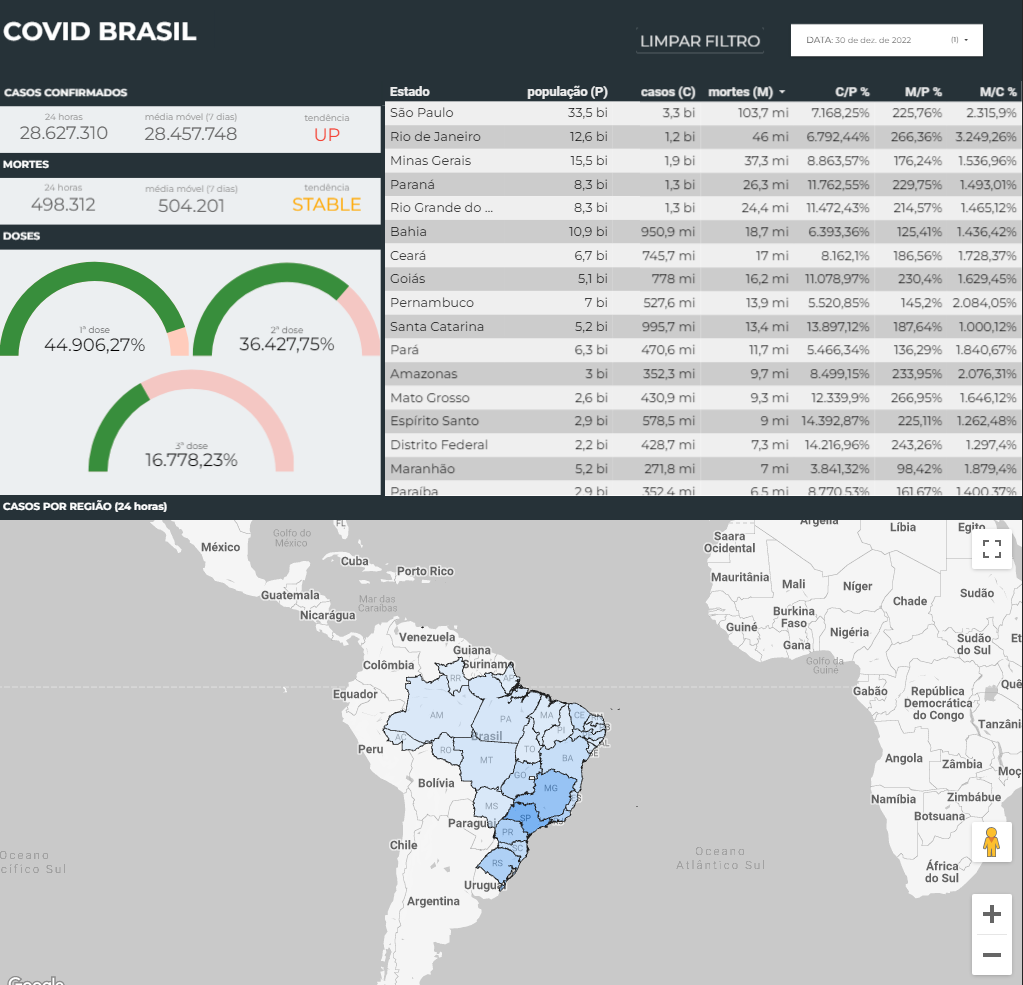

</center>